# Обнаружение мошенничества с кредитными картами на базе Apache Spark


Цель лабораторной работы: прогнозирование мошеннических операций при использовании кредитных карт с помощью классических методов машинного обучения. 
Для получения качественного результата используется программная платформа Apache Spark.

**Набор данных:**
транзакции, совершенные по кредитным картам в 2013 года европейскими держателями карт. 
В наборе данных представлены транзакции, произошедшие за 2 дня – 284 807 транзакций. Данные содержат только числовые входные переменные, которые являются результатом преобразования PCA.
Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA - это "Время" и "Сумма". Признак "Класс" является целевой переменной и принимает значение 1 в случае мошенничества и 0 в противном случае.
 	Источник данных: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?datasetId=310&sortBy=voteCount



**Apache Spark** - платформа параллельной обработки с открытым исходным кодом, которая поддерживает обработку в памяти, повышая производительность приложений для анализа больших данных. Подсистема обработки Spark призвана ускорить разработку, повысить удобство использования и реализовать сложную аналитику. Возможности распределенного вычисления в памяти Spark отлично подходят для итеративных алгоритмов в машинном обучении и графовых вычислениях. 

In [119]:
import warnings 
warnings.filterwarnings('ignore')

In [120]:
!pip install pyspark  #PySpark
!pip install findspark
!pip install -q kaggle
!apt-get install openjdk-8-jdk-headless -qq > /dev/null           #java 8 
!wget -q https://downloads.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip -q creditcardfraud.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open creditcardfraud.zip, creditcardfraud.zip.zip or creditcardfraud.zi

In [121]:
import os                                     # библиотека функций для работы с операционной системой
import findspark # выполняет поиск установки pyspark на сервере и добавляет путь установки PySpark sys.path во время выполнения, чтобы импортировать модули PySpark
import pyspark
import pandas as pd
from pyspark.sql import SparkSession          # SparkSession можно использовать для создания DataFrame, регистрации DataFrame в качестве таблиц, выполнения SQL над таблицами
from pyspark import SparkContext, SparkConf   # SparkContext предоставляет соединение с кластером Spark и может использоваться для создания RDD и трансляции переменных в этом кластере
from pyspark.sql.functions import *           # Список встроенных функций, доступных для DataFrame
from pyspark.sql.window import Window         # Window функции используются для вычисления результатов, таких как ранг, номер строки и т. д., по диапазону входных строк

# ИМПОРТИРУЕМ   Machine Learning Library (MLlib) это библиотека машинного обучения (ML) Spark. 
# Цель - сделать практическое машинное обучение масштабируемым и простым. На высоком уровне он предоставляет такие инструменты, как:
# * Алгоритмы ML (ML Algorithms): общие алгоритмы обучения, такие как классификация, регрессия, кластеризация и совместная фильтрация
# * Функционализация (Featurization): извлечение объектов, преобразование, уменьшение размерности и выбор
# * Конвейеры (Pipelines): инструменты для построения, оценки и настройки конвейеров ML
# * Сохранение (Persistence): сохранение и загрузка алгоритмов, моделей и конвейеров
# * Утилиты (Utilities): линейная алгебра, статистика, обработка данных и т.д.

from pyspark.ml import Pipeline  # Конвейеры ML - единый набор высокоуровневых API, построенных поверх фреймов данных, которые помогают создавать и настраивать конвейеры ML
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer # Индексатор меток, который сопоставляет строковый столбец меток со столбцом ML индексов меток
from pyspark.ml.evaluation import BinaryClassificationEvaluator # Оценщик для бинарной классификации
from pyspark.ml.linalg import DenseVector # Плотный вектор, представленный массивом значений
from pyspark.sql.types import *  # базовый класс всех типов данных в PySpark
import pyspark.sql.functions as F # Список встроенных функций, доступных для DataFrame
import numpy as np
from sklearn.model_selection import train_test_split # исп. для быстрого разделения массива или матрицы на train и test
from pyspark.ml.classification import LogisticRegression as LR_sp
from sklearn.metrics import confusion_matrix # матрица путаницы для оценки точности классификации
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


import seaborn as sns   # библиотека для создания статистических графиков на Python
from matplotlib import pyplot as plt

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"                   # работает со словарем переменных пользовательской среды
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"
findspark.init('/content/spark-3.3.1-bin-hadoop3')
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [122]:
from google.colab import drive 
drive.mount('/content/gdrive/', force_remount=True)
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Mounted at /content/gdrive/


In [123]:
data_path = 'gdrive/MyDrive/data/creditcard.csv'
data = spark.read.csv(data_path, inferSchema=True, header=True)
#просмотр данных через систему Spark
data.show(10)

+----+------------------+-------------------+------------------+------------------+-------------------+-------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                V4|                 V5|                 V6|                  V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|                V16|                V17|                V18|                V19|                V20|                 V21|          

In [124]:
spark = SparkSession.builder.appName("Python Spark SQL basic example").config("spark.some.config.option", "some-value").getOrCreate()
data_0 = spark.read.load(data_path, format = 'csv', header = 'true', interSchema = 'true')
pyspark.sql.dataframe.DataFrame
print('Проверим количество записей для каждого класса')
classFreq = data_0.groupBy("Class").count()
classFreq.show()

Проверим количество записей для каждого класса
+-----+------+
|Class| count|
+-----+------+
|    0|284315|
|    1|   492|
+-----+------+



In [125]:
data = data_0.toPandas() #Конвертируем в датафрейм Pandas, для удобства визуализации
data = data.sample(frac=1)
fraud_df = data.loc[data['Class']=='1']
non_fraud_df = data.loc[data['Class']=='0'] [:1000]    #берем 1000 строк class 0
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
new_df = normal_distributed_df.sample(frac = 1, random_state = 42)
new_df.shape

(1492, 31)

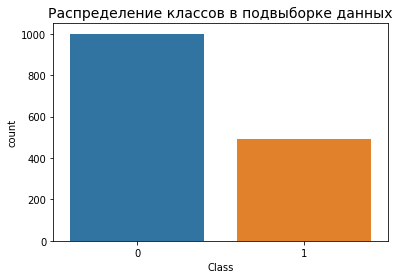

In [126]:
sns.countplot(x ='Class', data = new_df)
plt.title('Распределение классов в подвыборке данных', fontsize =14)
plt.show()

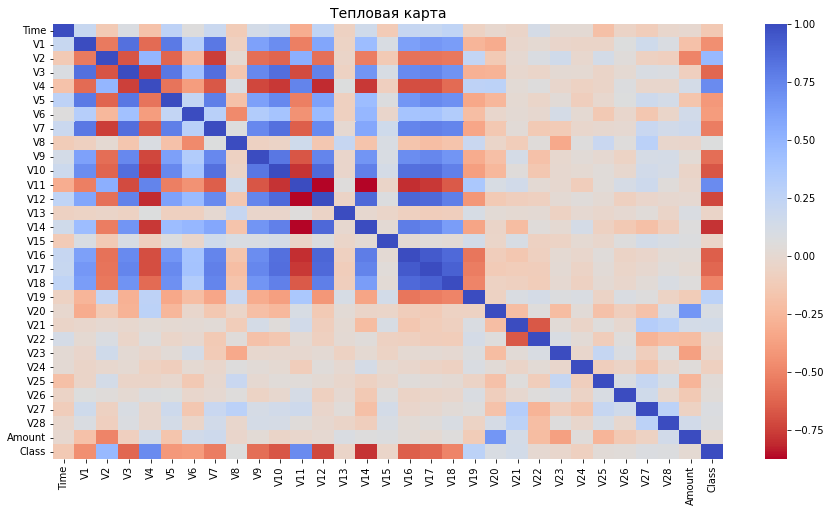

In [127]:
f, ax1 = plt.subplots(1, 1, figsize=(15,8))
sub_sample_corr = new_df.astype(float).corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':15}, ax=ax1)
ax1.set_title('Тепловая карта', fontsize=14)  
plt.show()   #где цвет синий, там связь выше

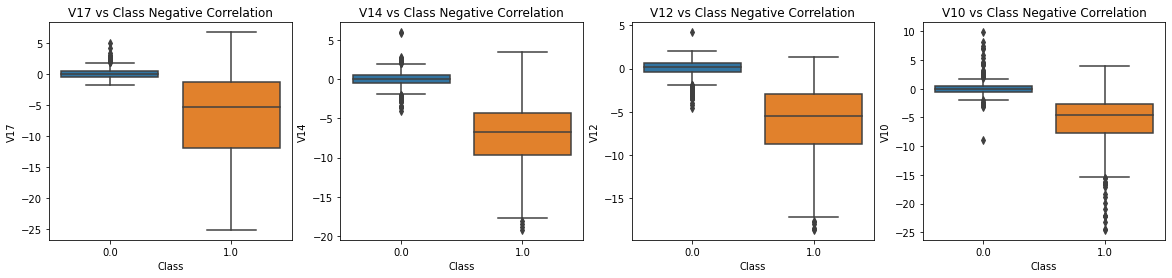

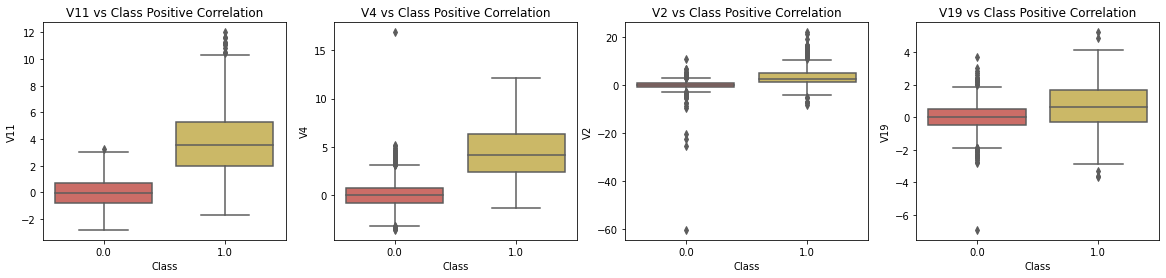

In [128]:
# Отрицательные корреляции (чем ниже значение, тем больше вероятность, что это будет мошенническая транзакция)
new_df=new_df.astype(float) 
f, axes = plt.subplots(ncols=4, figsize=(20,4))
sns.boxplot(x="Class", y="V17", data=new_df,  ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')
sns.boxplot(x="Class", y="V14", data=new_df,  ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')
sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')
sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')
plt.show()

# Положительные корреляции (чем выше функция, тем выше вероятность того, что это будет мошенническая транзакция)
colors = sns.color_palette("hls", 8)
f, axes = plt.subplots(ncols=4, figsize=(20,4))
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')
sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')
sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')
sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')
plt.show()

In [129]:
# Устранение выбросов 
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25
v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)

v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)

v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)

In [130]:
# Разделение DataFrame на тренировочный и тестовый. test_size - доля набора данных для включения в тестовое разделение -20%
# random_state - управляет перетасовкой, применяемой к данным перед применением разделения
train_data_pd, test_data_pd = train_test_split(new_df, test_size=0.2, random_state=40) 

train_data = spark.createDataFrame(train_data_pd)
win = Window().orderBy('Time')
train_data = train_data.withColumn("idx", row_number().over(win))
train_data = train_data.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31]))
train_data = spark.createDataFrame(train_data,["features","label","index"])
train_data = train_data.select("index","features","label")
train_data = train_data.withColumn("label",train_data.label.cast(IntegerType()))

test_data = spark.createDataFrame(test_data_pd)
win = Window().orderBy('Time')
test_data = test_data.withColumn("idx", row_number().over(win))
test_data = test_data.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31]))
test_data = spark.createDataFrame(test_data,["features","label","index"])
test_data = test_data.select("index","features","label")
test_data = test_data.withColumn("label",test_data.label.cast(IntegerType()))

In [131]:
train_data.groupBy("label").count().show() # Train

+-----+-----+
|label|count|
+-----+-----+
|    1|  372|
|    0|  786|
+-----+-----+



In [132]:
test_data.groupBy("label").count().show()  # Test

+-----+-----+
|label|count|
+-----+-----+
|    1|   85|
|    0|  205|
+-----+-----+



# Gradient-Boosted Trees
Алгоритм обучения деревьев с градиентным усилением (GBT) для классификации.Он поддерживает бинарные метки, а также непрерывные функции и категории.
Градиентный бустинг - это метод машинного обучения, используемый в задачах регрессии и классификации. Он дает модель прогнозирования в виде совокупности слабых моделей прогнозирования, которые обычно представляют собой деревья решений. Когда дерево решений является слабым учеником, результирующий алгоритм называется деревьями с градиентным усилением. Модель деревьев с градиентным усилением строится поэтапно, но он обобщает другие методы, позволяя оптимизировать произвольную дифференцируемую функцию потерь.
https://en.wikipedia.org/wiki/Gradient_boosting




In [133]:
gbt = GBTClassifier(featuresCol="features", maxIter=100, maxDepth=8, seed=40) 
model = gbt.fit(train_data)
predictions = model.transform(test_data)
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  211|
|       1.0|   79|
+----------+-----+



In [134]:
evaluator = BinaryClassificationEvaluator() # Классификационная метрика позволяет оценивать производительность модели машинного обучения
print(evaluator.evaluate(predictions))      # ожидает на вход: rawPrediction, label и необязательного столбца weight. Столбец rawPrediction может быть типа double (двоичное предсказание 0/1 
                                            # или вероятность метки 1) или типа vector (вектор длины-2 необработанных прогнозов, оценок или вероятностей меток)

0.9635581061692984


In [135]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0)) #True Positives
#predictions.groupBy("fraudPrediction").count().show()

In [136]:
#predictions.groupBy("label").count().show()

In [137]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]   #предсказание мошенничества
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100   # Sensitivity Точность прогнозирования
#FraudPredictionAccuracy  

84.70588235294117

In [138]:
#вычислим матрицу путаницы для оценки полученных результатов:

tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()  #True Positives
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()  #True Negatives
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()  #False Positives ошибка I типа (Actual NO, Predicted YES) операция не мошенническая, а представлена мошен.
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()  #False Negatives ошибка II типа (Actual YES, Predicted NO) операция мошенническая, а представлена не мошен.


print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)
print("\n") 
print(f'Sensitivity: {tp/(tp+fn)*100:.2f}%')         # recall (отзыв) чувствительность - насколько хорошо модель предсказала фактические события YES
print(f'Specificity: {tn/(tn+fp)*100:.2f}%')         # recall специфика - насколько хорошо модель предсказала фактические события NO
print(f'Precision: {tp/(tp+fp)*100:.2f}%')           # точность - сколько из всех предсказаний YES было верных
print(f'Accuracy: {(tp+tn)/(tp+tn+fp+fn)*100:.2f}%') # точность -из всех прогнозов, сделанных моделью, какой процент оказался верным
print(f'F1 Score: {(2*(tp/(tp+fp))*(tp/(tp+fn)))/(tp/(tp+fp)+tp/(tp+fn))*100:.2f}%') #В стат.анализе бинарной классификации явл. мерой точности теста - гармоническое среднее точности и отзыва


True Positive:  72 
True Negative:  198 
False Positive:  7 
False Negative:  13


Sensitivity: 84.71%
Specificity: 96.59%
Precision: 91.14%
Accuracy: 93.10%
F1 Score: 87.80%


AUC ROC - Area Under the ROC (Receiver Operating Characteristic) Curve
график, позволяющий оценить качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака, верно классифицированных как несущие признак (англ. true positive rate, TPR, называемой чувствительностью алгоритма классификации), и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущие признак (англ. false positive rate, FPR, величина 1-FPR называется специфичностью алгоритма классификации) при варьировании порога решающего правила.

Также известна как кривая ошибок. Анализ классификаций с применением ROC-кривых называется ROC-анализом

https://ru.wikipedia.org/wiki/ROC-кривая

In [139]:
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve: {:.4f}".format(auroc))

Area under ROC Curve: 0.9636


In [140]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)
    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points
    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

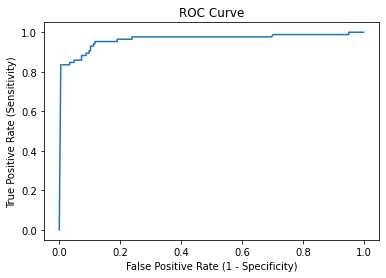

In [141]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(x_val, y_val)

# Логистическая регрессия (spark)
В spark.ml логистическая регрессия может использоваться для прогнозирования бинарного результата с помощью биномиальной логистической регрессии или для прогнозирования многоклассового результата с помощью мультиномиальной логистической регрессии. 

In [142]:
lr_sp = LR_sp(featuresCol="features", maxIter=100)
lrModel_sp = lr_sp.fit(train_data)

In [143]:
predictions_lr_sp = lrModel_sp.transform(test_data)
predictions_lr_sp.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  208|
|       1.0|   82|
+----------+-----+



In [144]:
print(evaluator.evaluate(predictions_lr_sp))

0.973486370157822


In [145]:
predictions_lr_sp = predictions_lr_sp.withColumn("fraudPrediction",when((predictions_lr_sp.label==1)&(predictions_lr_sp.prediction==1),1).otherwise(0))
predictions_lr_sp.groupBy("fraudPrediction").count().show()
accurateFraud = predictions_lr_sp.groupBy("fraudPrediction").count().where(predictions_lr_sp.fraudPrediction==1).head()[1]
totalFraud = predictions_lr_sp.groupBy("label").count().where(predictions_lr_sp.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100
FraudPredictionAccuracy

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   78|
|              0|  212|
+---------------+-----+



91.76470588235294

In [146]:
#вычислим матрицу пуктаницы для оценки полученных результатов:
tp = predictions_lr_sp[(predictions_lr_sp.label == 1) & (predictions_lr_sp.prediction == 1)].count() #True Positives
tn = predictions_lr_sp[(predictions_lr_sp.label == 0) & (predictions_lr_sp.prediction == 0)].count() #True Negatives
fp = predictions_lr_sp[(predictions_lr_sp.label == 0) & (predictions_lr_sp.prediction == 1)].count() #False Positives ошибка I типа (Actual NO, Predicted YES) операция не мошенническая, а представлена мошен.
fn = predictions_lr_sp[(predictions_lr_sp.label == 1) & (predictions_lr_sp.prediction == 0)].count() #False Negatives ошибка II типа (Actual YES, Predicted NO) операция мошенническая, а представлена не мошен.

print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)
print("\n") 
print(f'Sensitivity: {tp/(tp+fn)*100:.2f}%')         # recall (отзыв) чувствительность - насколько хорошо модель предсказала фактические события YES
print(f'Specificity: {tn/(tn+fp)*100:.2f}%')         # recall специфика - насколько хорошо модель предсказала фактические события NO
print(f'Precision: {tp/(tp+fp)*100:.2f}%')           # точность - сколько из всех предсказаний YES было верных
print(f'Accuracy: {(tp+tn)/(tp+tn+fp+fn)*100:.2f}%') # точность -из всех прогнозов, сделанных моделью, какой процент оказался верным
print(f'F1 Score: {(2*(tp/(tp+fp))*(tp/(tp+fn)))/(tp/(tp+fp)+tp/(tp+fn))*100:.2f}%') #В стат.анализе бинарной классификации явл. мерой точности теста - гармоническое среднее точности и отзыва


True Positive:  78 
True Negative:  201 
False Positive:  4 
False Negative:  7


Sensitivity: 91.76%
Specificity: 98.05%
Precision: 95.12%
Accuracy: 96.21%
F1 Score: 93.41%


In [147]:
evaluator_lr_sp = BinaryClassificationEvaluator() # Классификационная метрика позволяет оценивать производительность модели машинного обучения
print(evaluator_lr_sp.evaluate(predictions_lr_sp))

0.973486370157822


In [148]:
# она описывает взаимосвязь между чувствительностью модели (TPR, или true positives rate — доля истинно положительных примеров) 
# и её специфичностью (описываемой в отношении долей ложноположительных результатов: 1-FPR)


auroc_lr_sp = evaluator_lr_sp.evaluate(predictions_lr_sp, {evaluator_lr_sp.metricName: "areaUnderROC"})
print("Area under ROC Curve: {:.4f}".format(auroc_lr_sp))

Area under ROC Curve: 0.9735


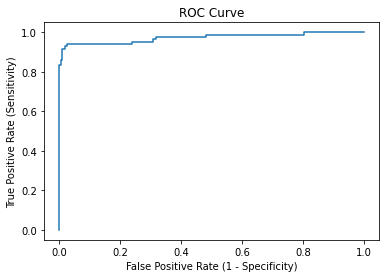

In [149]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
preds_1 = predictions_lr_sp.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds_1).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(x_val, y_val)

# Логистическая регрессия (sklearn)
Логистическая регрессия — это разновидность множественной регрессии, общее назначение которой состоит в анализе связи между несколькими независимыми переменными (называемыми также регрессорами или предикторами) и зависимой переменной. Бинарная логистическая регрессия применяется в случае, когда зависимая переменная является бинарной (т.е. может принимать только два значения). С помощью логистической регрессии можно оценивать вероятность того, что событие наступит.

In [150]:
X_train = train_data_pd.drop(['Class'], axis=1).values
y_train = train_data_pd['Class'].values
X_test = test_data_pd.drop(['Class'], axis=1).values
y_test = test_data_pd['Class'].values

In [151]:
log_regression = LogisticRegression()
log_regression. fit (X_train,y_train)

LogisticRegression()

In [152]:
predictions = log_regression.predict(X_test)
#print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions)

array([[199,   6],
       [  8,  77]])

In [153]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)
print("\n") 
print(f'Sensitivity: {tp/(tp+fn)*100:.2f}%')         # recall (отзыв) чувствительность - насколько хорошо модель предсказала фактические события YES
print(f'Specificity: {tn/(tn+fp)*100:.2f}%')         # recall специфика - насколько хорошо модель предсказала фактические события NO
print(f'Precision: {tp/(tp+fp)*100:.2f}%')           # точность - сколько из всех предсказаний YES было верных
print(f'Accuracy: {(tp+tn)/(tp+tn+fp+fn)*100:.2f}%') # точность -из всех прогнозов, сделанных моделью, какой процент оказался верным
print(f'F1 Score: {(2*(tp/(tp+fp))*(tp/(tp+fn)))/(tp/(tp+fp)+tp/(tp+fn))*100:.2f}%') #В стат.анализе бинарной классификации явл. мерой точности теста - гармоническое среднее точности и отзыва


True Positive:  77 
True Negative:  199 
False Positive:  6 
False Negative:  8


Sensitivity: 90.59%
Specificity: 97.07%
Precision: 92.77%
Accuracy: 95.17%
F1 Score: 91.67%


In [154]:
y_pred_proba = log_regression. predict_proba (X_test)[::, 1 ]
auc = metrics. roc_auc_score (y_test, y_pred_proba)
print("Area under ROC Curve: {:.4f}".format(auc))

Area under ROC Curve: 0.9678


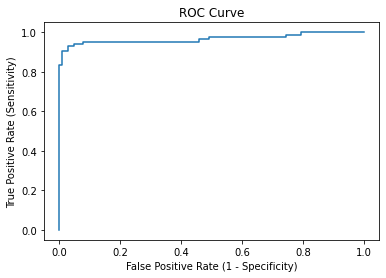

In [155]:
fpr, tpr, _ = metrics. roc_curve (y_test, y_pred_proba)
plt.plot (fpr,tpr)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show() 